# Battle Ship

In [30]:
import numpy as np
import random
random.seed(42)

import seaborn as sns
import matplotlib.pylab as plt

We define some helper functions first

In [31]:
def plot_board(board):
    """Plot a battleship board."""
    sns.heatmap(board, linewidths=0.5, linecolor="black", cbar=False)
    plt.show()

## 1. Representing the game

We represent the opponents board as a 2D boolean array, where True means the cell has a ship and False means it doesn't. 

In [32]:
class Board:
    def __init__(self):
        self.board = np.array([[False] * 10] * 10)

    def __str__(self):
        return str(self.board)

    def place_ship(self, ship, is_vert, row, col):
        """
        row, col is top left corner of ships
        Returns True if ship was placed successfully and False otherwise
        Assumes row, col in range [0, 9]
        """
        if is_vert:
            # Make sure ship doesn't go off the board
            if row + ship.length > 10:
                return False
            board_slice = self.board[row:row + ship.length, col]
            if np.any(board_slice):
                return False
            self.board[row:row + ship.length, col] = True
        else:
            # Make sure ship doesn't go off the board
            if col + ship.length > 10:
                return False
            board_slice = self.board[row, col:col + ship.length]
            if np.any(board_slice):
                return False
            self.board[row, col:col + ship.length] = True
        return True

    def generate_random_board(self, ships):
        for ship in ships:
            placed = False
            while not placed:
                is_vert = random.choice([True, False])
                row = random.randint(0, 9)
                col = random.randint(0, 9)
                placed = self.place_ship(ship, is_vert, row, col)

We then have 5 types of ships: Carried, Battleship, Cruiser, Submarine and Destroyer. These have length 5, 4, 3, 3 and 2 respectively. 

In [33]:
class Ship:
    def __init__(self, name, length):
        self.name = name
        self.length = length
        
ships = [Ship("Carrier", 5), Ship("Battleship", 4), Ship("Cruiser", 3), Ship("Submarine", 3), Ship("Destroyer", 2)]

We can now initialise a new board a place a ship

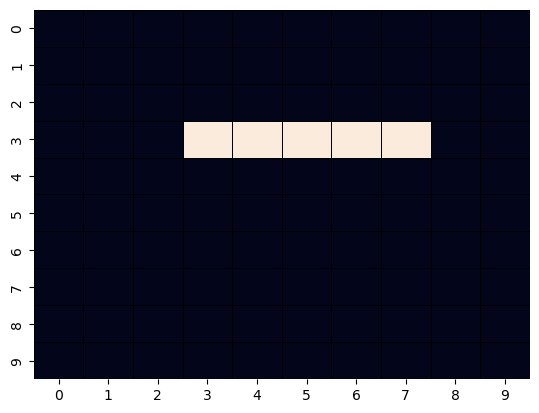

In [34]:
test_board = Board()
test_board.place_ship(ships[0], False, 3, 3)
plot_board(test_board.board)

Lets try randomly placing all our ships now

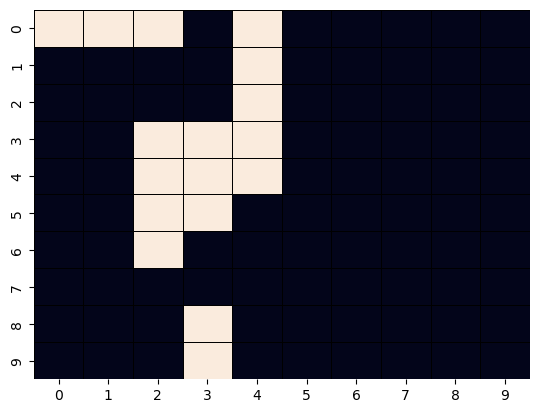

In [35]:
test_board = Board()
test_board.generate_random_board(ships)
plot_board(test_board.board)